# Do larger snags stand longer?—snag longevity in mixed conifer–hardwood forests in Hokkaido, Japan

- Probability do not start at 1:
    - "The probability of a snag still be standing when TSD=0 in our model could be inferred as the probability that a dead tree will become a snag (Fig. 1). The probabilities of a snag with a DBH of 25 cm still standing when TSD=0 were 0.85 for Acer pictum,0.72for Phellodendron Amurense, and 0.45–0.65 for the other species that we studied (Fig. 1)."
- The authors explicitly include the informtion about the percentage of dead standing trees that become a snag at time of death (TSD) and the percentage of trees which fall to the ground at time of death. Therefore, we can assume that at TSD=0 all snags (DSTs) are standing.
- The values determined here from Figure 1:
    
<div>
<img src="snag_fall_rates/Onodera2015DoJapan_fig1.png" width="500"/>
</div>    



In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.interpolate import interp1d
import sys

sys.path.append('/Users/antje/Update_PIK/')

from classes import snag_MTF_func as sg
from classes import boundaries as bd
from classes import functions as fcy

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

inch_to_cm = 2.54

%matplotlib inline
%config Completer.use_jedi = False 

In [3]:
##############
#   Import   #
##############
    
reference = 'Onodera2015DoJapan'

species  = [# Conifers 
            ['Sakhalin fir', 'Abies sachalinensis'], 
            ['Spruce', 'Picea spp.'],    
            ['Mizunara', 'Quercus crispula'],
            ['Amur cork tree', 'Phellodendron amurense'],
            ['Yellow-paint maple', 'Acer pictum'],
            ['Japanese linden', 'Tilia japonica'],
            ['Other Hardwoods', 'Angiospermae']           
           ]

 
country            = 'Japan' # old-growth, old-growth
region             = 'Hokkaido'
biome              = 'Temperate'
site_name          = np.nan
mean_tC            = np.mean([3.3,7.2]) # [°C]
mean_precip_mm     = np.mean([1205,2221])  # [mm]
y_coords           = 43.348889 # geogrpahical centre of Hokkaido
x_coords           = 142.384167
tlag               = np.nan
mean_age           = np.nan
elevation          = np.mean([100,670]) # from google maps terrain
min_height         = np.nan # m
min_diam           = 12 # cm
max_diam           = np.array([74,104,156,44,78,74,86]) # species Table 1

DBH_classes        = np.nan
DBH_species_mean   = np.array([35,37,25,19,24,24,21]) # Table 1 - excluding other conifers - cause not analysed
DBH_classes_mean   = np.nan

species_ntrees     = np.array([110,17,19,18,15,17,97]) # Table 1 - Only standing dead

# n trees / species weighted mean DBH
mean_DBH           = np.sum(DBH_species_mean * species_ntrees) / np.sum(species_ntrees) 
height_mean        = np.nan
max_diam_weighted  = np.sum(max_diam * species_ntrees) / np.sum(species_ntrees) 

diameter_prc       = np.nan

management         = 'Unmanaged'
n_plots            = 37 # number of plots / site
plot_size          = (1*0.5+4*1+32*0.25) / n_plots  # ha
mortality_cause    = np.nan


species_abundance_prc = species_ntrees / np.sum(species_ntrees)
age_classes           = np.nan

tree_share_to_snag    = np.nan

method_snag_field_measurement_list = ['Remeasurement', 'Chronosequence', 'Survey']
method_snag_field_measurement      = method_snag_field_measurement_list[0]+': 1970 - 2011'

tree_density       = np.nan # trees / ha
speciesDOM         = 'Abies sachalinensis' # scientific only
speciesDOM_prc     = (species_ntrees / species_ntrees.sum() * 100)[0]# dominant tree species percentage of total

#—- Method
# Load data types
dt = pd.read_excel("snag_fall_rates/201210_data_types_MTF_literature.xlsx", index_col=None, header=[0,1])['Data types']
method_snag_field_measurement      = dt.columns[(dt == reference).any()].item()
ntree_Total                        = np.sum(species_ntrees)
Remeasurement_interval_avg         = np.mean([3,9])     # years
survey_duration_total              = 42 # years
survey_start_yr                    = 1970
survey_end_yr                      = 2011
TSD_determination_method           = 'Permanent sample plots'#cf. Method_snagfall_measurement -> Dendrochronology, Chronosequence, None if mean fall /year
Model_type_fracRemain_snag         = 'generalized linear mixed model (GLMM) (link function=logit, error distribution=binomial)'# ‘negative exponential…
Model_type_fracRemain_snag_sigCov  = 'species dependent'# significant (p<0.05) co-variats
Model_type_fracRemain_snag_nsigCov = np.nan # not significant co-variats


# Snag recruitment rate [snags/ha/year]
snags_ha_year = np.nan



# Path to data
path = '../data/snag_fall_rates/'

onodera_fig1 = pd.read_csv(path+reference+'_fig1.csv', 
               header=[0,1]
                )

Figure1 re-drawn


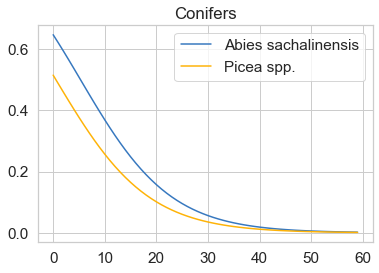

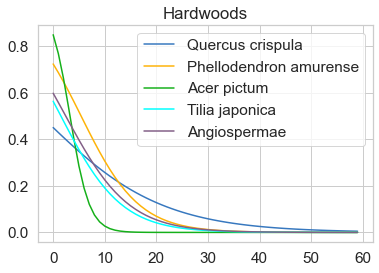

In [4]:
# 0 means there is no relationship in the model
coefficients = [
                [0.102, -0.114,0.020], # AS
                [0.057,-0.112, 0], # P. spp
                [0.378,-0.086,-0.023,], # QC
                [-0.934,-0.178,0.076], #PA
                [1.735,-0.531,0], # AP
                [0.257,-0.17,0], # TJ
                [-0.301,-0.163,0.028] # other hardwoods
               ]

x = np.arange(0,60)

def func_onodera(coef, x, dbh):
    intercept = coef[0]
    TSD = coef[1]
    DBH = coef[2]
    
    # GLMM
    # Linear predictor
    LP = intercept + TSD*x + DBH*dbh
    
    # Logit link
    p = np.exp(LP)/(1+np.exp(LP))
    
    return p

print('Figure1 re-drawn')
dbh = 25
for s in range(len(coefficients[:2])):
    plt.title('Conifers')    
    plt.plot(x,func_onodera(coefficients[s],x,dbh), label=species[s][1])
plt.legend()
plt.show()    

for s in range(len(coefficients[2:])):
    plt.title('Hardwoods')
    plt.plot(x,func_onodera(coefficients[s+2],x,dbh), label=species[s+2][1])    
plt.legend()
plt.show()



In [5]:
# Re-do for mean DBH
x = np.arange(0,60)
y = np.empty((len(species),len(x)))
tree_share_to_snag = np.empty((len(species),))
                              
for s in range(len(coefficients)):
    dbh = DBH_species_mean[s]
    y[s,:] = func_onodera(coefficients[s],x,dbh)
    tree_share_to_snag[s] = y[s,0]*100
    y[s,:] = y[s,:]/y[s,0] # Normalising the curves such that all DSTs are standing at time of death 
    
tree_share_to_snag_weighted = np.sum(tree_share_to_snag * species_ntrees)/np.sum(species_ntrees)    

In [6]:
#-------------------------#
#   Save the input data   #
#-------------------------#

#— Raw data
ys = y.tolist()
xs = [x.tolist()] * len(y)


DBH_class = [DBH_classes] * len(y)
DBH_min = [min_diam] * len(y)
DBH_max = max_diam.tolist()
DBH_mean = DBH_species_mean.tolist()
ntree_DBH = species_ntrees
species_ntree = species_ntrees
cmass_whole = [np.nan] * len(x)
cmass_ts = [np.nan] * len(x)
species_list = [species[i][0] for i in range(len(species))] 
species_scientific_list = [species[i][1] for i in range(len(species))] 
site_name_list = [np.nan] * len(y)
sg.save_MTF_input(xs, ys, 
                  species_list, 
                  species_scientific_list,
                  method_snag_field_measurement, 
                  reference,
                  DBH_class = DBH_class,
                  DBH_min = DBH_min,
                  DBH_max = DBH_max,
                  DBH_mean = DBH_mean, 
                  species_ntree = species_ntrees,
                  DBH_ntree = ntree_DBH,
                  cmass_whole = cmass_whole,
                  cmass_ts = cmass_ts,
                  site_name = site_name_list
                  )


True
species <class 'list'>
DBH_mean <class 'list'>
x <class 'list'>
y <class 'list'>


,x,y,y.unit,species,species_scientific,species_ntree,DBH_class,DBH_min,DBH_max,DBH_mean,DBH_ntree,cmass_whole,cmass_ts,DT_method,site_name,Reference
0,0.0,1.000000,count,Oaks,Quercus spp.,87.666667,<10,5.0,9.0,7.0,87.666667,572.244494,NaN,TS_survey.species_DBHclasses,Cadwell Memorial Forest,Wilson2005DynamicsForest
1,10.0,0.290000,count,Oaks,Quercus spp.,87.666667,<10,5.0,9.0,7.0,87.666667,572.244494,NaN,TS_survey.species_DBHclasses,Cadwell Memorial Forest,Wilson2005DynamicsForest
2,20.0,0.069600,count,Oaks,Quercus spp.,87.666667,<10,5.0,9.0,7.0,87.666667,572.244494,NaN,TS_survey.species_DBHclasses,Cadwell Memorial Forest,Wilson2005DynamicsForest
3,0.0,1.000000,count,Oaks,Quercus spp.,76.000000,10-20,10.0,19.0,14.0,76.000000,2660.357417,NaN,TS_survey.species_DBHclasses,Cadwell Memorial Forest,Wilson2005DynamicsForest
4,10.0,0.450000,count,Oaks,Quercus spp.,76.000000,10-20,10.0,19.0,14.0,76.000000,2660.357417,NaN,TS_survey.species_DBHclasses,Cadwell Memorial Forest,Wilson2005DynamicsForest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,55.0,0.000298,count,Other Hardwoods,Angiospermae,97.000000,NaN,12.0,86.0,21.0,97.000000,NaN,NaN,TS_model.species_DBHclasses,NaN,Onodera2015DoJapan
416,56.0,0.000253,count,Other Hardwoods,Angiospermae,97.000000,NaN,12.0,86.0,21.0,97.000000,NaN,NaN,TS_model.species_DBHclasses,NaN,Onodera2015DoJapan
417,57.0,0.000215,count,Other Hardwoods,Angiospermae,97.000000,NaN,12.0,86.0,21.0,97.000000,NaN,NaN,TS_model.species_DBHclasses,NaN,Onodera2015DoJapan
418,58.0,0.000183,count,Other Hardwoods,Angiospermae,97.000000,NaN,12.0,86.0,21.0,97.000000,NaN,NaN,TS_model.species_DBHclasses,NaN,Onodera2015DoJapan


In [7]:
max_diam = np.mean(max_diam)
sg.store_single_loc(country,
                    region,
                    biome,
                    site_name,
                    y_coords,
                    x_coords,
                    min_height,
                    min_diam,
                    max_diam,
                    speciesDOM,
                    speciesDOM_prc,
                    mortality_cause,
                    management,
                    mean_age,
                    method_snag_field_measurement,
                    tree_share_to_snag_weighted,
                    n_plots,
                    plot_size,
                    ntree_Total,
                    tree_density,
                    Remeasurement_interval_avg,
                    survey_duration_total,
                    survey_start_yr,
                    survey_end_yr,
                    TSD_determination_method,
                    Model_type_fracRemain_snag,
                    Model_type_fracRemain_snag_sigCov,
                    Model_type_fracRemain_snag_nsigCov,
                    elevation,
                    mean_tC,
                    mean_precip_mm,
                    reference)

removing the old ENTRY


/Users/antje/Update_PIK/classes/snag_MTF_func.py:1762: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sites = sites.append(next_row,ignore_index=True)


,Country,Region,Site name,Biome,Y coords,X coords,Minimum height,Minimum diameter,Maximum diameter,Dominant species,...,survey_start_yr,survey_end_yr,TSD_determination_method,Model_type_fracRemain_snag,Model_type_fracRemain_snag_sigCov,Model_type_fracRemain_snag_nsigCov,Elevation,Paper_T°C,Paper_precip_mm,Reference
0,USA,Colorado,,Temperate,39.904739,-105.883172,NaN,10.0,NaN,Pinus contorta,...,2007.0,2018.0,Pine bark and needle properties following Safr...,mean annual fall,NaN,NaN,3122.000000,1.20,750.0,Rhoades2020SnagfallUSA
1,Canada,Newfoundland,,Boreal,49.004048,-57.961591,1.5,9.0,NaN,Abies balsamea,...,1907.0,2006.0,Chronosequence of years since harvest,Frac remain after 20 years,NaN,NaN,NaN,NaN,1200.0,Smith2009SnagForests
2,Canada,New Brunswick,,Boreal,47.350562,-66.472890,NaN,9.1,NaN,Abies balsamea,...,1983.0,2005.0,"Re-measurement, PSP",Halflife,NaN,NaN,330.555556,NaN,NaN,Taylor2007DeadCanada
3,USA,Massachusetts,Cadwell Memorial Forest,Temperate,42.366667,-72.433333,NaN,5.0,50.0,Quercus spp.,...,1983.0,2003.0,Fall rate between survey intervals,NaN,NaN,NaN,322.500000,NaN,NaN,Wilson2005DynamicsForest
4,USA,Oregon,Starkey Experimental Forest,Temperate,45.219650,-118.563032,NaN,NaN,NaN,Pinus ponderosa,...,1975.0,1982.0,Survey,Observation,NaN,NaN,1297.500000,NaN,NaN,Bull1983LongevityWoodpeckers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Canada,Saskatchewan,Jenpeg- poor,Boreal,54.640625,-98.044169,NaN,NaN,NaN,Pinus banksiana,...,1935.0,1995.0,Dendrochronology,"Single exponential model, maximum likelihood e...",NaN,NaN,NaN,NaN,NaN,Metsaranta2008DendrochronologicalCanada
127,Canada,Saskatchewan,Thompson- rich,Boreal,55.778676,-97.839332,NaN,NaN,NaN,Pinus banksiana,...,1935.0,1995.0,Dendrochronology,"Single exponential model, maximum likelihood e...",NaN,NaN,NaN,NaN,NaN,Metsaranta2008DendrochronologicalCanada
128,Canada,Saskatchewan,Thompson- poor,Boreal,55.778676,-97.839332,NaN,NaN,NaN,Pinus banksiana,...,1935.0,1995.0,Dendrochronology,"Single exponential model, maximum likelihood e...",NaN,NaN,NaN,NaN,NaN,Metsaranta2008DendrochronologicalCanada
129,Spain,Granada,,Savannah,36.969972,-3.500472,NaN,NaN,NaN,Pinus spp.,...,2007.0,2011.0,Re-measurement,"linear mixed-effects model: thinning, elevatio...","DBH, management",elevation,1742.666667,NaN,572.0,Molinas-Gonzalez2017FallMountain
